Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import collections
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## To use the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## To run update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [ ]:
# Get the image count for test and train images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images:

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Training dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
  )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
  )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# we can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Create the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123
  )

Found 118 files belonging to 9 classes.


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
# Checking the images and labels shapes
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


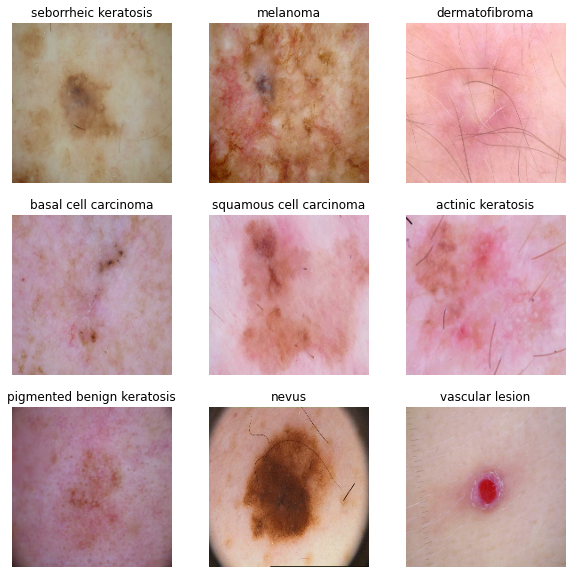

In [ ]:
# Visualise one image of each instance of class
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
class_get = []
for images, labels in train_ds.take(1):
    index = 0
    for i in range(31):
        if class_names[labels[i]] not in class_get:
            ax = plt.subplot(3, 3, index + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            class_get.append(class_names[labels[i]])
            index += 1


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Create a vanilla CNN model
model = Sequential()
model.add(
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
)

model.add(
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal")
)
model.add(layers.MaxPooling2D((2, 2)))
model.add(
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Choose an appropirate optimiser and loss function
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 215168)            0

### Train the model

In [ ]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
169/169 [==============================] - 1636s 2s/step - loss: 3.5010 - accuracy: 0.2409 - val_loss: 1.4079 - val_accuracy: 0.4722
Epoch 2/20
169/169 [==============================] - 6s 37ms/step - loss: 1.4397 - accuracy: 0.4442 - val_loss: 1.2656 - val_accuracy: 0.5256
Epoch 3/20
169/169 [==============================] - 6s 37ms/step - loss: 1.2280 - accuracy: 0.5527 - val_loss: 1.2968 - val_accuracy: 0.5486
Epoch 4/20
169/169 [==============================] - 6s 37ms/step - loss: 1.0460 - accuracy: 0.6312 - val_loss: 1.0222 - val_accuracy: 0.6377
Epoch 5/20
169/169 [==============================] - 6s 37ms/step - loss: 0.8023 - accuracy: 0.7229 - val_loss: 0.9145 - val_accuracy: 0.6860
Epoch 6/20
169/169 [==============================] - 6s 37ms/step - loss: 0.6195 - accuracy: 0.7904 - val_loss: 1.0056 - val_accuracy: 0.7023
Epoch 7/20
169/169 [==============================] - 6s 37ms/step - loss: 0.5011 - accuracy: 0.8266 - val_loss: 1.0623 - val_accuracy: 0.721

### Visualizing training results

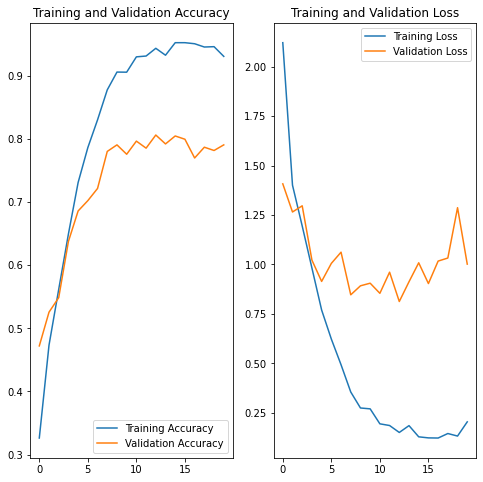

In [ ]:
# Visualise Training vs Validation Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Get the model test score
score = model.evaluate(test_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 49s 112ms/step - loss: 8.9395 - accuracy: 0.3305
Test loss: 8.939488410949707
Test accuracy: 0.3305084705352783


### Findings here



*   We get an accuracy of **93.05%** for Training and an accuracy of **79.06%** for validation.
*   **Training accuracy >> Validation accuracy**, so it is overfitting
*   We should try to avoid the overfitting by adding data augumentation strategy and Dropout layers







In [ ]:
# Choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
        "horizontal", input_shape=(img_height, img_width, 3)
    ),
    layers.experimental.preprocessing.RandomFlip(
        "vertical", input_shape=(img_height, img_width, 3)
    ),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.3),
  ]
)

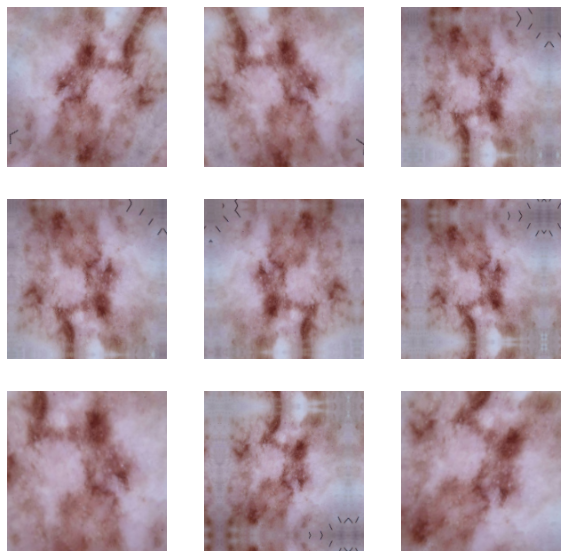

In [ ]:
# visualise augmentation
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


### Create the model, compile and train the model


In [ ]:
## Use the dropout layer if there is a any chances of overfitting:
model = Sequential()
model.add(data_augmentation)
model.add(
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
)

model.add(
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal")
)
model.add(layers.MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(9, activation='softmax'))



### Compiling the model

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Model Summary:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 64)       

### Training the model

In [ ]:
## train  model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
169/169 [==============================] - 9s 46ms/step - loss: 6.0737 - accuracy: 0.1266 - val_loss: 2.1879 - val_accuracy: 0.1403
Epoch 2/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1843 - accuracy: 0.1389 - val_loss: 2.1852 - val_accuracy: 0.1403
Epoch 3/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1754 - accuracy: 0.1474 - val_loss: 2.1862 - val_accuracy: 0.1403
Epoch 4/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1757 - accuracy: 0.1395 - val_loss: 2.1871 - val_accuracy: 0.1403
Epoch 5/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1770 - accuracy: 0.1389 - val_loss: 2.1873 - val_accuracy: 0.1403
Epoch 6/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1820 - accuracy: 0.1320 - val_loss: 2.1844 - val_accuracy: 0.1418
Epoch 7/20
169/169 [==============================] - 7s 44ms/step - loss: 2.1835 - accuracy: 0.1377 - val_loss: 2.1809 - val_accuracy: 0.1455

### Visualizing the results

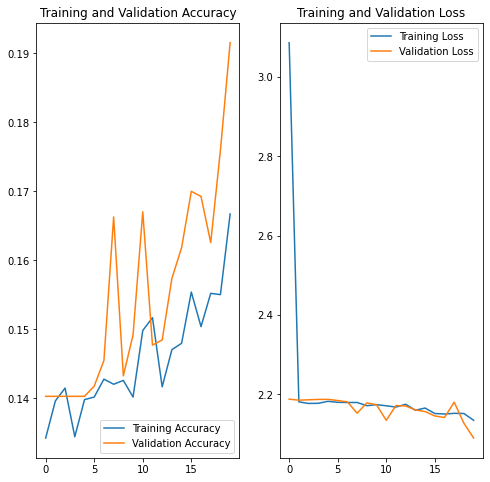

In [ ]:
# Visualise the training vs validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Getting the test score
score = model.evaluate(test_ds, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 4s 16ms/step - loss: 2.1997 - accuracy: 0.1525
Test loss: 2.1996543407440186
Test accuracy: 0.1525423675775528


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

*   We can say that by adding proper data augmentation strategy and Dropout layers, We have actualy prevented the model from overfitting.
*   Now, the accuracy for training is **16.31%** and that of validation dataset is **19.15%**, which is now comparable




#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Get class distribution
def get_class_distribution(dataset):
    """ Function to calculate the class distribution
    """
    class_distribution = {}
    for element in dataset.as_numpy_iterator():
        for label in element[1]:
            if class_names[label] in class_distribution.keys():
                class_distribution[class_names[label]] += 1
            else:
                class_distribution[class_names[label]] = 0

    # sort dict by key
    class_distribution = collections.OrderedDict(sorted(class_distribution.items())) 
    return class_distribution


In [ ]:
# Get the full dataset
full_ds = train_ds.concatenate(val_ds)
# Get the class distribution
train_ds_class_dist = get_class_distribution(full_ds)

In [ ]:
# Class distribution in Train dataset
train_ds_class_dist

OrderedDict([('actinic keratosis', 613),
             ('basal cell carcinoma', 875),
             ('dermatofibroma', 594),
             ('melanoma', 937),
             ('nevus', 856),
             ('pigmented benign keratosis', 961),
             ('seborrheic keratosis', 576),
             ('squamous cell carcinoma', 680),
             ('vascular lesion', 638)])

In [ ]:
# Getting the class distribution percentage wise:
def get_class_distribution_percentage(class_dist):
    """ Function to calculate the percentage of class distribution
    """
    total = sum(class_dist.values())
    for key, value in class_dist.items():
        percent = round((value/total) * 100, 2)
        print("{:<30s}:   {} or {}%".format(key, value, percent))

get_class_distribution_percentage(train_ds_class_dist)

actinic keratosis             :   613 or 9.11%
basal cell carcinoma          :   875 or 13.0%
dermatofibroma                :   594 or 8.83%
melanoma                      :   937 or 13.92%
nevus                         :   856 or 12.72%
pigmented benign keratosis    :   961 or 14.28%
seborrheic keratosis          :   576 or 8.56%
squamous cell carcinoma       :   680 or 10.1%
vascular lesion               :   638 or 9.48%


#### Findings: 
#### - Which class has the least number of samples?
Ans: **Seborrheic keratosis** has got the least number of samples. It has got only **576** samples or constitute only **8.56%** percentage compared to the total training samples.

#### - Which classes dominate the data in terms proportionate number of samples?
Ans: **Pigmented benign keratosis** class dominate the data in terms of samples and it constitutes around **14.28%** of overall training samples.
The second and third highest class which dominate the data in these samples are **Melanoma** and **Basal cell carcinoma** which constitutes around **13.92% **and **13.0%** respectively.


####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Initiate a `Pipeline` object pointing to a directory containing initial image data set.<br>
2. Define the number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset= str(data_dir_train) + os.path.sep

import Augmentor
for i in class_names:
    print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEBA075FB90>: 100%|██████████| 500/500 [00:18<00:00, 26.52 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB6C061050>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB646EF6D0>: 100%|██████████| 500/500 [00:18<00:00, 26.67 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7FEB646E1F50>: 100%|██████████| 500/500 [01:24<00:00,  5.89 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1022x767 at 0x7FEBA0724D90>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEBB83DB290>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEC1A3553D0>: 100%|██████████| 500/500 [00:41<00:00, 12.15 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma


Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB64701110>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEB6466DF90>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEBA07241D0>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# Get the total count of images created
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# Get the list of all path:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010737.jpg_88ba1f0b-bddb-4259-852d-348ce48110be.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000302.jpg_9d8adfeb-9a80-49f4-a8e1-99e5eabbbf90.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010251.jpg_7bee1cf0-2da2-4253-9dfc-d8733136f762.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010516.jpg_6ade2ee4-f5be-4478-ae0a-5764f81f36e4.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_

In [ ]:
# Getting the corresponding class names:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
# Create a dictionary to contain the mappings:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
# Getting all the list of path for existing old images:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000139.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000143.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000141.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000144.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000142.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000159.jpg',
 '/content/gdrive/MyDrive/Datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melano

In [ ]:
# Getting the list of all class names corresponding for existing old images:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list


['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [ ]:
# Creating dataframe which contains the image path and the corresponding label for the existing training dataset
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [ ]:
# Create the dataframe which contains the image path and the corresponding label for the newly created training dataset
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
# Getting the new class distribution
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [ ]:
# Have some the of the data from the combined dataframe
new_df

,Path,Label
0,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,melanoma
1,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,melanoma
2,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,melanoma
3,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,melanoma
4,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,melanoma
...,...,...
8995,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis
8996,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis
8997,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis
8998,/content/gdrive/MyDrive/Datasets/CNN_assignmen...,seborrheic keratosis


#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


####  Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## Create model with normalisation and Dropout layers
model = Sequential()
model.add(
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
)
model.add(
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal")
)
model.add(layers.MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(9, activation='softmax'))

#### Compile your model

In [ ]:
## Compile the model
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 43, 43, 64)       

#### Train the model

In [ ]:
# Train the model with epochs as 30
epochs = 30
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/30
281/281 [==============================] - 72s 251ms/step - loss: 5.1594 - accuracy: 0.1165 - val_loss: 2.1918 - val_accuracy: 0.1331
Epoch 2/30
281/281 [==============================] - 68s 237ms/step - loss: 2.1928 - accuracy: 0.1223 - val_loss: 2.1902 - val_accuracy: 0.1331
Epoch 3/30
281/281 [==============================] - 67s 236ms/step - loss: 2.1923 - accuracy: 0.1219 - val_loss: 2.1896 - val_accuracy: 0.1331
Epoch 4/30
281/281 [==============================] - 67s 236ms/step - loss: 2.1921 - accuracy: 0.1241 - val_loss: 2.1887 - val_accuracy: 0.1326
Epoch 5/30
281/281 [==============================] - 67s 234ms/step - loss: 2.1830 - accuracy: 0.1316 - val_loss: 2.1922 - val_accuracy: 0.1344
Epoch 6/30
281/281 [==============================] - 67s 234ms/step - loss: 2.1409 - accuracy: 0.1615 - val_loss: 1.8722 - val_accuracy: 0.3227
Epoch 7/30
281/281 [==============================] - 67s 234ms/step - loss: 1.8818 - accuracy: 0.2685 - val_loss: 1.6914 - val_ac

#### **Todo:**  Visualize the model results

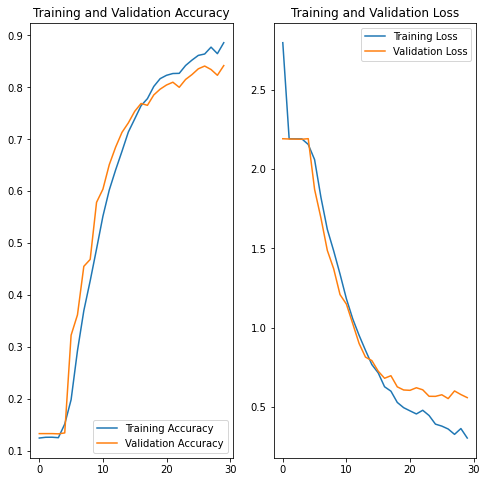

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Yes, the approach of class re-balance actually improved the overall accuracy for the training & validation dataset, and it is also avoid the model being overfitted.
- New Training Accuracy: **88.50%**
- New Validation Accuracy: **84.20%**